In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from wordcloud import WordCloud
from collections import Counter

# Read in Dataset

In [2]:
df = pd.read_csv('cleaned_reviews.csv', parse_dates = ['Time']).sort_values('Time', ignore_index = True)
df['year'] = df.Time.dt.year
df['month'] = df.Time.dt.month.map("{:02}".format)
df['day'] = df.Time.dt.day.map("{:02}".format)
df['yearmonth'] = df.year.astype('str') + '-' + df.month.astype('str')
df['num_of_words'] = df.processed_text.apply(lambda x:len(x.split()))
df

,Sentiment,Time,Text,processed_text,year,month,day,yearmonth,num_of_words
0,0,2017-07-12,Drew's makes some fantastic dressings. Their ...,draw make fantastic dress italian dress exampl...,2017,07,12,2017-07,135
1,0,2017-07-12,It's so hard to find no sodium seasonings (oth...,hard find sodium season mrs dash great product...,2017,07,12,2017-07,10
2,0,2017-07-12,I got this cookie as a part of my Mom Box from...,get cookie part mom box voxbox keen oatmeal co...,2017,07,12,2017-07,25
3,1,2017-07-12,I purchased two types of stevia to try to move...,purchase two type stevia try move use artifici...,2017,07,12,2017-07,43
4,0,2017-07-12,"For quite a while, before Amazon starting reta...",quite amazon start retail food items nearly im...,2017,07,12,2017-07,61
...,...,...,...,...,...,...,...,...,...
5439,0,2021-12-10,"Great product. No fat. All natural, nothing ad...",great product fat natural nothing add great cr...,2021,12,10,2021-12,12
5440,1,2021-12-10,I purchased this item because it was cheaper t...,purchase item cheaper olive juices look good q...,2021,12,10,2021-12,46
5441,0,2021-12-10,"Buy it now, please. These are just great, with...",buy please great perfect flavor texture keep r...,2021,12,10,2021-12,20
5442,0,2021-12-10,The crackers are very tasty and we just tried ...,crackers tasty try little salsa top healthy lo...,2021,12,10,2021-12,17


In [3]:
df.isna().sum()

Sentiment         0
Time              0
Text              0
processed_text    0
year              0
month             0
day               0
yearmonth         0
num_of_words      0
dtype: int64

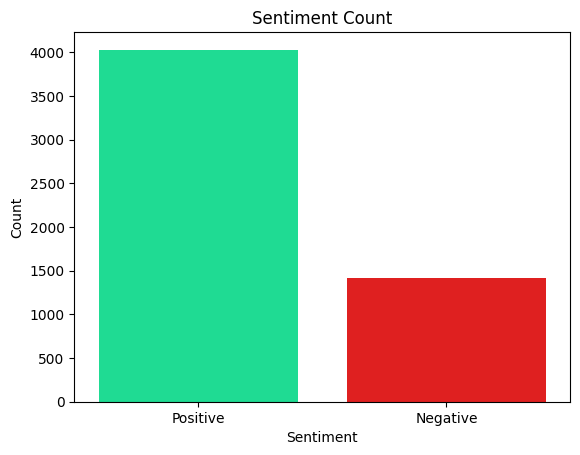

In [4]:
sns.countplot(data = df, x = 'Sentiment', palette=['mediumspringgreen','red'])
plt.title('Sentiment Count')
plt.xlabel('Sentiment')
plt.xticks([0,1], ['Positive', 'Negative'])
plt.ylabel('Count')
plt.show()

# Trends in Number of Reviews

## Yearly

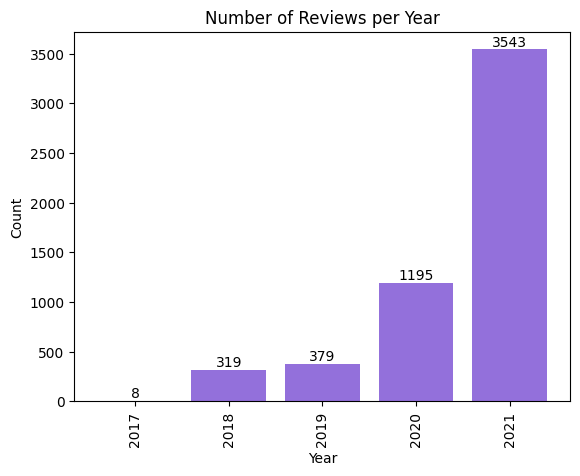

In [5]:
ax = df.groupby('year').size().plot.bar(color = 'mediumpurple', width = 0.8)
ax.bar_label(ax.containers[0])
plt.title('Number of Reviews per Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

## Monthly

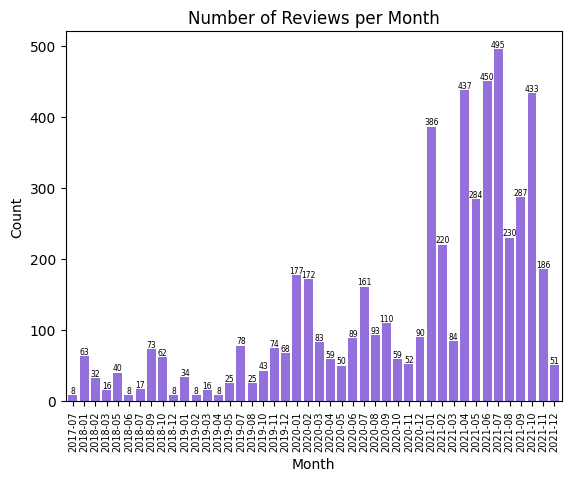

In [6]:
ax = df.groupby('yearmonth').size().plot.bar(color = 'mediumpurple', width = 0.8)
ax.bar_label(ax.containers[0], fontsize = 5.5)
plt.title('Number of Reviews per Month')
plt.xlabel('Month')
plt.xticks(fontsize = 7)
plt.ylabel('Count')
plt.show()

## Daily

In [7]:
# split daily count based on years, exclude 2017 since all reviews come from the same day (2017-07-12)
df_2018 = pd.DataFrame(df.loc[df.year == 2018,].groupby('Time').size()).rename(columns = {0:'count'})
df_2019 = pd.DataFrame(df.loc[df.year == 2019,].groupby('Time').size()).rename(columns = {0:'count'})
df_2020 = pd.DataFrame(df.loc[df.year == 2020,].groupby('Time').size()).rename(columns = {0:'count'})
df_2021 = pd.DataFrame(df.loc[df.year == 2021,].groupby('Time').size()).rename(columns = {0:'count'})

df_list = [df_2018, df_2019, df_2020, df_2021]
subplot_title_list = ['2018', '2019', '2020', '2021']

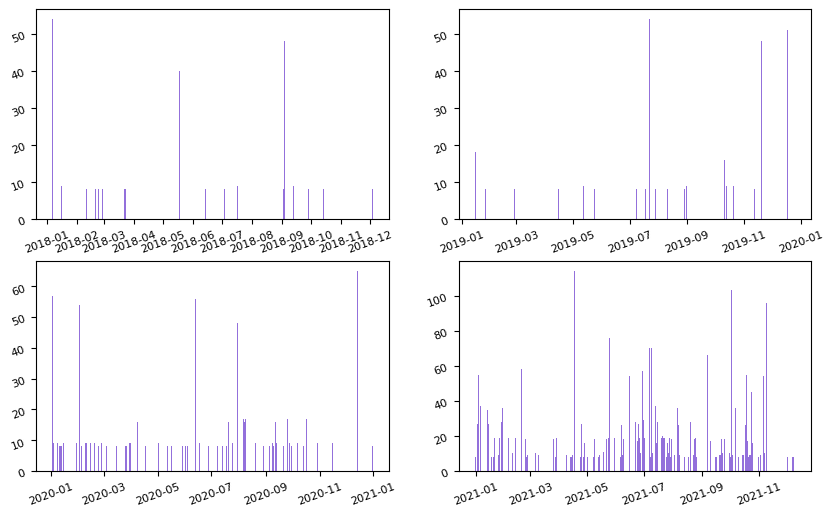

In [8]:
f, ax = plt.subplots(2, 2, figsize = (10, 6))

for i, dataframe in enumerate(df_list):
    ax.flatten()[i].bar(data = dataframe.reset_index(), x = 'Time', height = 'count', color = 'mediumpurple')
    ax.flatten()[i].tick_params(labelsize = 8, labelrotation = 20)
    #ax.flatten()[i].set_title(subplot_title_list[i])
#plt.suptitle('Number of Reviews per Day')
plt.show()

# Average Sentiments across Months and Years

## Yearly

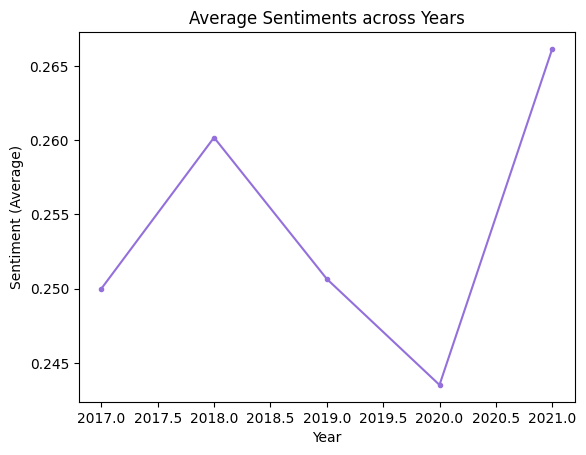

In [9]:
df.groupby('year')['Sentiment'].mean().plot.line(style = '.-', color = 'mediumpurple')
plt.title('Average Sentiments across Years')
plt.xlabel('Year')
plt.ylabel('Sentiment (Average)')
plt.show()

## Monthly

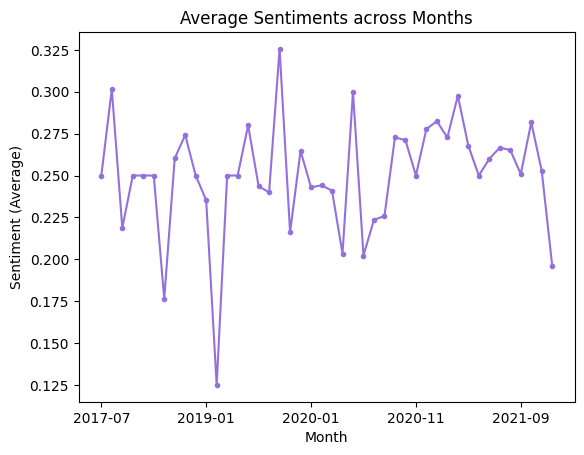

In [10]:
df.groupby('yearmonth')['Sentiment'].mean().plot.line(style = '.-', color = 'mediumpurple')
plt.title('Average Sentiments across Months')
plt.xlabel('Month')
plt.ylabel('Sentiment (Average)')
plt.show()

## Daily

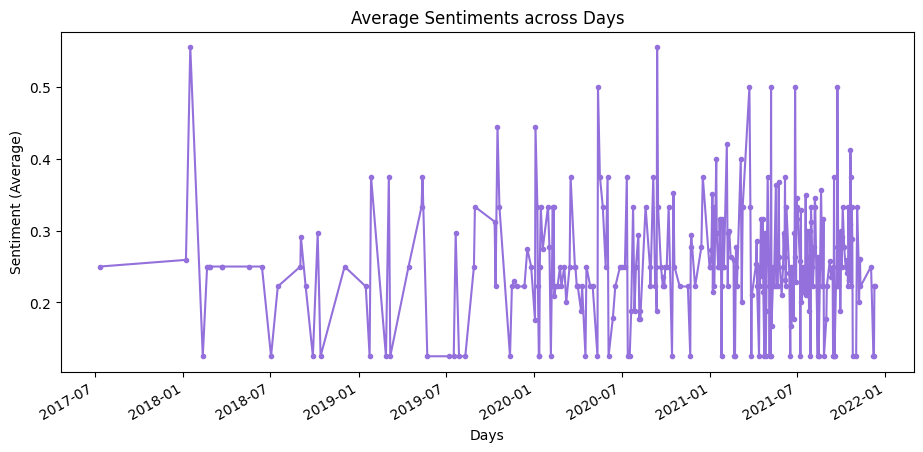

In [11]:
plt.figure(figsize = (11,5))
df.groupby('Time')['Sentiment'].mean().plot.line(style = '.-', color = 'mediumpurple')
plt.title('Average Sentiments across Days')
plt.xlabel('Days')
plt.ylabel('Sentiment (Average)')
plt.show()

## Positive vs Negative Sentiments

In [12]:
positive_df = df.loc[df.Sentiment == 0]
positive_size_df = positive_df.groupby('yearmonth').size()

negative_df = df.loc[df.Sentiment == 1]
negative_size_df = negative_df.groupby('yearmonth').size()

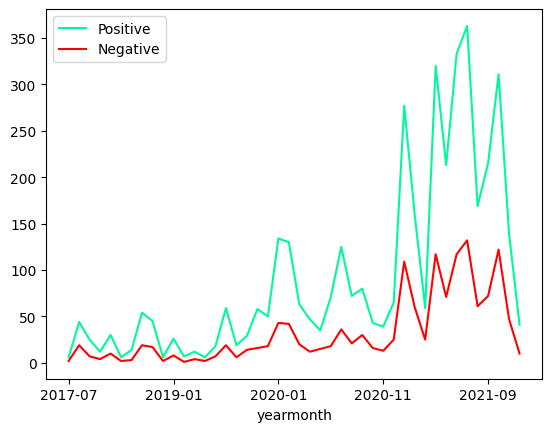

In [13]:
ax = positive_size_df.plot.line(color = 'mediumspringgreen')
negative_size_df.plot.line(ax = ax, color = 'red')
ax.legend(["Positive", "Negative"])
plt.show()

# WordCloud

## Overall

In [14]:
overall_common_words = ""
for text in df.processed_text:
    text = str(text)
    tokens = text.split()
    overall_common_words += " ".join(tokens)+" "

In [15]:
overall_wordcloud = WordCloud(width = 1000, height = 1000,
                background_color ='black',
                min_font_size = 10,
                colormap = 'Purples',
                random_state = 0).generate(overall_common_words)

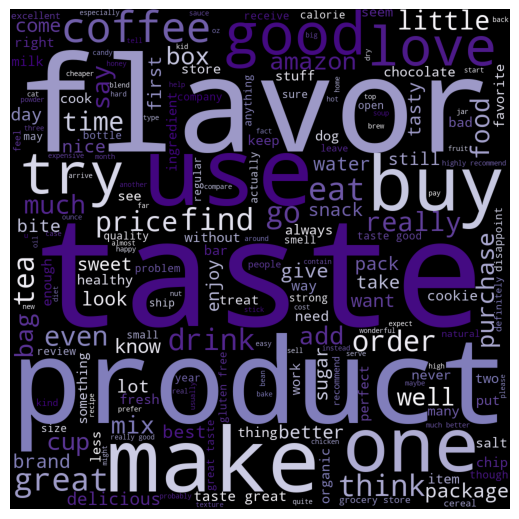

In [16]:
plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(overall_wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

## Positive

In [17]:
positive_common_words = ""
for text in df.loc[df.Sentiment == 0].processed_text:
    text = str(text)
    tokens = text.split()
    positive_common_words += " ".join(tokens)+" "

In [18]:
positive_wordcloud = WordCloud(width = 500, height = 500,
                background_color ='black',
                min_font_size = 10,
                colormap = 'Greens',
                random_state = 0).generate(positive_common_words)

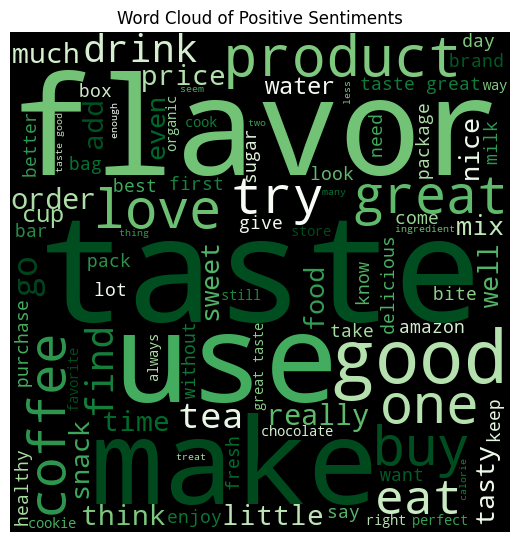

In [19]:
plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(positive_wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Word Cloud of Positive Sentiments')
plt.show()

## Negative

In [20]:
negative_common_words = ""
for text in df.loc[df.Sentiment == 1].processed_text:
    text = str(text)
    tokens = text.split()
    negative_common_words += " ".join(tokens)+" "

In [21]:
negative_wordcloud = WordCloud(width = 500, height = 500,
                background_color ='Black',
                min_font_size = 10,
                colormap = 'Reds',
                random_state = 0).generate(negative_common_words)

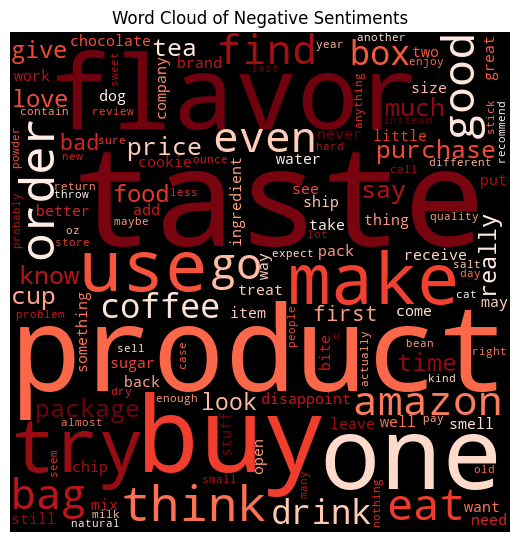

In [22]:
plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(negative_wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Word Cloud of Negative Sentiments')
plt.show()

# Number of Words in Reviews

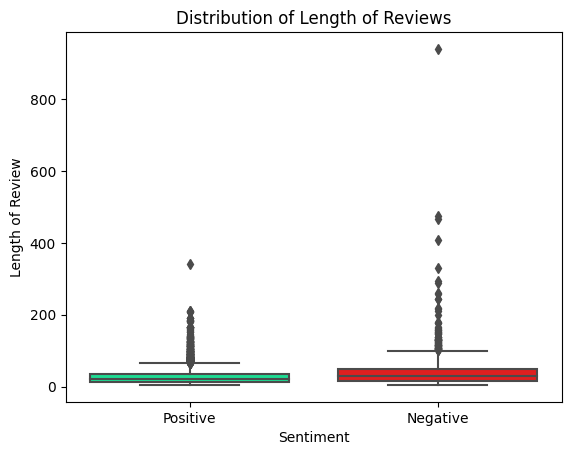

In [23]:
sns.boxplot(data = df, x = 'Sentiment', y = 'num_of_words', palette = ['mediumspringgreen', 'red'])
plt.title('Distribution of Length of Reviews')
plt.xticks([0, 1], ['Positive', 'Negative'])
plt.ylabel('Length of Review')
plt.show()

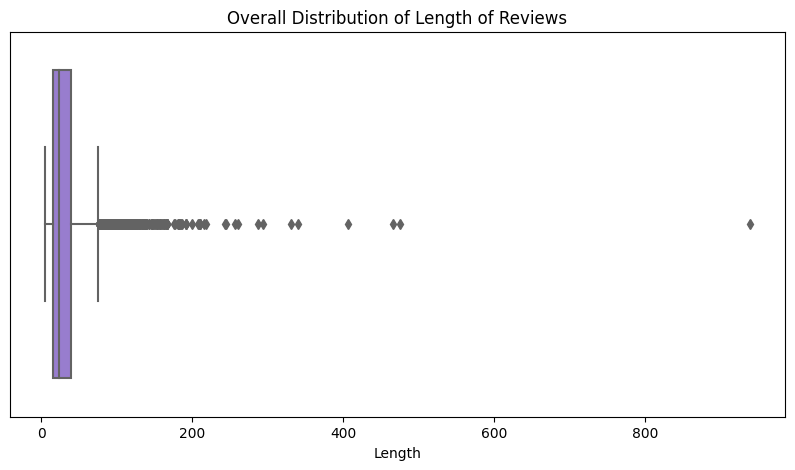

In [24]:
plt.figure(figsize = (10,5))
sns.boxplot(x = df['num_of_words'], color = 'mediumpurple')
#sns.stripplot(x = df['num_of_words'], color = 'grey', alpha = 0.2)
plt.title('Overall Distribution of Length of Reviews')
plt.xlabel('Length')
plt.yticks([])
plt.show()

# Analyse the Words for Positive and Negative Sentiments

In [25]:
list_of_text_positive = df.loc[df.Sentiment == 0]['processed_text'].apply(lambda x:str(x).split())
positive_top = Counter([positive_item for positive_text in list_of_text_positive for positive_item in positive_text])
positive_top_n = pd.DataFrame(positive_top.most_common(20))
positive_top_n.columns = ['common_words','count']
positive_top_n.style.background_gradient(cmap = 'Greens')

,common_words,count
0,taste,2401
1,great,1650
2,like,1645
3,good,1499
4,flavor,1323
5,love,1142
6,make,1059
7,use,1012
8,buy,953
9,get,931


In [26]:
list_of_text_negative = df.loc[df.Sentiment == 1]['processed_text'].apply(lambda x:str(x).split())
negative_top = Counter([negative_item for negative_text in list_of_text_negative for negative_item in negative_text])
negative_top_n = pd.DataFrame(negative_top.most_common(20))
negative_top_n.columns = ['common_words','count']
negative_top_n.style.background_gradient(cmap = 'Reds')

,common_words,count
0,taste,869
1,like,752
2,product,557
3,buy,536
4,get,498
5,flavor,482
6,make,462
7,would,460
8,try,435
9,one,402


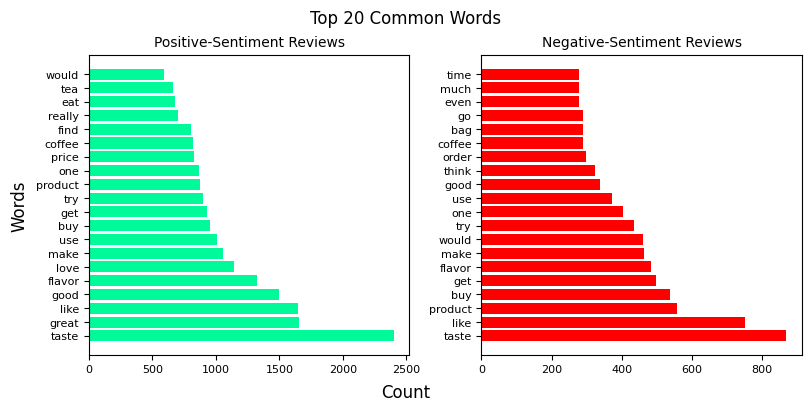

In [27]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8,4), constrained_layout=True)

ax1.barh(data = positive_top_n, y = 'common_words', width = 'count', color = 'mediumspringgreen')
ax1.set_title('Positive-Sentiment Reviews', fontsize = 10)
ax1.tick_params(axis = 'both', labelsize = 8)

ax2.barh(data = negative_top_n, y = 'common_words', width = 'count', color = 'red')
ax2.set_title('Negative-Sentiment Reviews', fontsize = 10)
ax2.tick_params(axis = 'both', labelsize = 8)

fig.suptitle('Top 20 Common Words')
fig.supylabel('Words')
fig.supxlabel('Count')
plt.show()

## Top 20 Common Words Exclusive to Both Sentiments

In [28]:
top_100_positive_words_df = pd.DataFrame(positive_top.most_common(100)).rename(columns = {0:'common_words', 1:'count'})
top_100_negative_words_df = pd.DataFrame(negative_top.most_common(100)).rename(columns = {0:'common_words', 1:'count'})

top_100_positive = top_100_positive_words_df.common_words.values
top_100_negative = top_100_negative_words_df.common_words.values

In [29]:
positive_words_to_take = np.array([positive not in top_100_negative for positive in top_100_positive]).astype(int)
negative_words_to_take = np.array([negative not in top_100_positive for negative in top_100_negative]).astype(int)

positive_to_index = np.where(positive_words_to_take == 1)[0][:20]
negative_to_index = np.where(negative_words_to_take == 1)[0][:20]

top_20_positive_exclusive = top_100_positive_words_df.iloc[positive_to_index].reset_index(drop = True)
top_20_negative_exclusive = top_100_negative_words_df.iloc[negative_to_index].reset_index(drop = True)

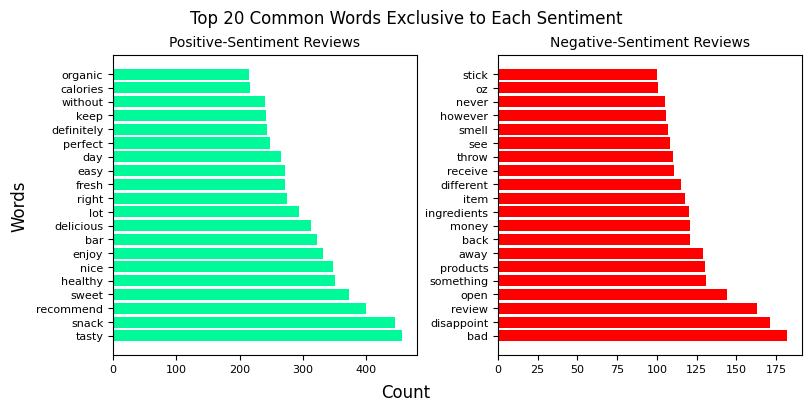

In [30]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8,4), constrained_layout=True)

ax1.barh(data = top_20_positive_exclusive, y = 'common_words', width = 'count', color = 'mediumspringgreen')
ax1.set_title('Positive-Sentiment Reviews', fontsize = 10)
ax1.tick_params(axis = 'both', labelsize = 8)

ax2.barh(data = top_20_negative_exclusive, y = 'common_words', width = 'count', color = 'red')
ax2.set_title('Negative-Sentiment Reviews', fontsize = 10)
ax2.tick_params(axis = 'both', labelsize = 8)

fig.suptitle('Top 20 Common Words Exclusive to Each Sentiment')
fig.supylabel('Words')
fig.supxlabel('Count')
plt.show()

### Finding negative sentiment reviews with the word 'good' in it (juz for own info)

In [31]:
list_of_negative_processed_text = df.loc[df.Sentiment == 1]['processed_text'].values
list_of_negative_text = df.loc[df.Sentiment == 1]['Text'].values
whether_good_in_text = np.array(['good' in text for text in list_of_negative_processed_text]).astype('int')
indices_good_in_text = np.where(whether_good_in_text == 1)

In [32]:
counter = 0

In [33]:
print(list_of_negative_text[indices_good_in_text][counter])
counter += 1

I like almost everything about this jerky, the toughness and chewiness. But it is just too salty. If you nibble it, you may enjoy it but that is not how i eat. Also, it is not good for my health to eat something this salty. I have run into too many of salty beef jerky patches recently. This review is for the wood smoked, but if other flavors contains the same amount of salt per serving, they will be just as salty. Why everything is either too fatty, sweet or salty??? Are they trying to get us addicted?
